In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics ,preprocessing
import pandas as pd
import itertools
import os
from sklearn.metrics import confusion_matrix


/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    'AccX',
    'AccY', 
    'AccZ', 
    'GyroX',
    'GyroY', 
    'GyroZ'
]

# Output classes to learn how to classify
LABELS = ['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying']
RAW_DATA_PATH = "../G9_data/sippets/"
SUBJECT_LIST = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26]


In [3]:
def load_data(Snippet_paths, n = 128):
    X_signals = []
    y_signals = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths:
        df = pd.read_csv(snippet_path, usecols=usecols)
        y_signals.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values.reshape(df.shape[0], df.shape[1])
        X_signals.append(c)
        
    return np.asarray(X_signals), np.asarray(y_signals)






## Utility functions for training:


In [4]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [5]:
n = ''
subject_no = 5
Snippet_paths_train =[]
Snippet_paths_test =[]
for fol in LABELS:
    folder = RAW_DATA_PATH+'/'+fol+'/'
    for root,dirs,files in os.walk(folder):
        for file_ in files:
            if file_.endswith(".csv"):
                if not int(file_.split("_")[0]) == subject_no:
                    Snippet_paths_train.append(folder+file_)
                elif int(file_.split("_")[0]) == subject_no:
                    Snippet_paths_test.append(folder+file_)

X_train,y_train = load_data(Snippet_paths_train,128)

X_test,y_test = load_data(Snippet_paths_test,128)

y_test = y_test - 1
y_train = y_train - 1



In [6]:
X_test.shape

(1026,)

In [7]:
import keras
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)

Using TensorFlow backend.


In [58]:
# Scaling
def scale_data(X_train, X_test):
    X_train_2d = X_train.transpose(2,0,1).reshape(6,-1).transpose()
    X_test_2d = X_test.transpose(2,0,1).reshape(6,-1).transpose()
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train_2d)
    X_train_scaled =  np.array([scaler.transform(X_train[i,:,:]) for i in range(X_train.shape[0])])
    X_test_scaled  =  np.array([scaler.transform(X_test[i,:,:]) for i in range(X_test.shape[0])])
    return X_train_scaled, X_test_scaled

In [8]:
X_train_used, X_test_used = X_train_padded, X_test_padded

## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [9]:
# Input Data 

training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test_used)  # 2947 testing series
n_steps = len(X_train_used[0])  # 128 timesteps per series
n_input = len(X_train_used[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test_used.shape, y_test.shape, np.mean(X_test_used), np.std(X_test_used))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
((1026, 128, 6), (1026, 1), -0.5365929337602633, 3.812752325644165)
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Let's get serious and build the neural network:

In [10]:
from tensorflow.python.framework import ops
ops.reset_default_graph()



In [11]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Hooray, now train the neural network:

In [12]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
saver = tf.train.Saver()
# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, '../Model_saved/model.ckpt')
print("Model restored from file: %s" % '../Model_saved/model.ckpt')


# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train_used, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test_used,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test_used,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT on Test Set: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


predictions = one_hot_predictions.argmax(1)


INFO:tensorflow:Restoring parameters from ../Model_saved/model.ckpt
Model restored from file: ../Model_saved/model.ckpt
Training iter #1500:   Batch Loss = 1.216903, Accuracy = 0.61333334446
PERFORMANCE ON TEST SET: Batch Loss = 3.46415090561, Accuracy = 0.301169604063
Training iter #30000:   Batch Loss = 3.206870, Accuracy = 0.0
PERFORMANCE ON TEST SET: Batch Loss = 1.32729613781, Accuracy = 0.59454190731
Training iter #60000:   Batch Loss = 0.863017, Accuracy = 0.776000022888
PERFORMANCE ON TEST SET: Batch Loss = 1.13119649887, Accuracy = 0.540935695171
Training iter #90000:   Batch Loss = 1.950115, Accuracy = 0.00999999977648
PERFORMANCE ON TEST SET: Batch Loss = 1.03890073299, Accuracy = 0.592592597008
Training iter #120000:   Batch Loss = 1.253230, Accuracy = 0.582666695118
PERFORMANCE ON TEST SET: Batch Loss = 1.00036633015, Accuracy = 0.679337203503
Training iter #150000:   Batch Loss = 2.436478, Accuracy = 0.0
PERFORMANCE ON TEST SET: Batch Loss = 1.06654727459, Accuracy = 0.64

Training iter #1590000:   Batch Loss = 2.078899, Accuracy = 0.0466666668653
PERFORMANCE ON TEST SET: Batch Loss = 0.982889354229, Accuracy = 0.657894730568
Training iter #1620000:   Batch Loss = 0.577547, Accuracy = 0.853999972343
PERFORMANCE ON TEST SET: Batch Loss = 0.936740338802, Accuracy = 0.68810915947
Training iter #1650000:   Batch Loss = 1.211015, Accuracy = 0.798666656017
PERFORMANCE ON TEST SET: Batch Loss = 0.897577226162, Accuracy = 0.787524342537
Training iter #1680000:   Batch Loss = 0.786495, Accuracy = 0.663999974728
PERFORMANCE ON TEST SET: Batch Loss = 0.879866302013, Accuracy = 0.777777791023
Training iter #1710000:   Batch Loss = 2.060697, Accuracy = 0.062666669488
PERFORMANCE ON TEST SET: Batch Loss = 0.896766126156, Accuracy = 0.745614051819
Training iter #1740000:   Batch Loss = 0.548221, Accuracy = 0.889333307743
PERFORMANCE ON TEST SET: Batch Loss = 0.900432825089, Accuracy = 0.760233938694
Training iter #1770000:   Batch Loss = 1.161669, Accuracy = 0.75599998

Training iter #3180000:   Batch Loss = 0.561856, Accuracy = 0.88666665554
PERFORMANCE ON TEST SET: Batch Loss = 0.683316886425, Accuracy = 0.808966875076
Training iter #3210000:   Batch Loss = 0.651089, Accuracy = 0.802666664124
PERFORMANCE ON TEST SET: Batch Loss = 0.616936087608, Accuracy = 0.839181303978
Training iter #3240000:   Batch Loss = 0.707815, Accuracy = 0.763333320618
PERFORMANCE ON TEST SET: Batch Loss = 0.659517288208, Accuracy = 0.803118884563
Training iter #3270000:   Batch Loss = 1.563219, Accuracy = 0.333333343267
PERFORMANCE ON TEST SET: Batch Loss = 0.651335179806, Accuracy = 0.823586761951
Training iter #3300000:   Batch Loss = 0.505600, Accuracy = 0.906666696072
PERFORMANCE ON TEST SET: Batch Loss = 0.662619173527, Accuracy = 0.800194919109
Training iter #3330000:   Batch Loss = 0.602211, Accuracy = 0.826666653156
PERFORMANCE ON TEST SET: Batch Loss = 0.638924241066, Accuracy = 0.81871342659
Training iter #3360000:   Batch Loss = 0.696056, Accuracy = 0.7620000243

Training iter #4800000:   Batch Loss = 0.637676, Accuracy = 0.801999986172
PERFORMANCE ON TEST SET: Batch Loss = 0.613560080528, Accuracy = 0.832358658314
Training iter #4830000:   Batch Loss = 1.428452, Accuracy = 0.338666677475
PERFORMANCE ON TEST SET: Batch Loss = 0.702533960342, Accuracy = 0.773879170418
Training iter #4860000:   Batch Loss = 0.493279, Accuracy = 0.903999984264
PERFORMANCE ON TEST SET: Batch Loss = 0.680620968342, Accuracy = 0.794346988201
Training iter #4890000:   Batch Loss = 0.559862, Accuracy = 0.841333329678
PERFORMANCE ON TEST SET: Batch Loss = 0.611121058464, Accuracy = 0.826510727406
Training iter #4920000:   Batch Loss = 0.603601, Accuracy = 0.801999986172
PERFORMANCE ON TEST SET: Batch Loss = 0.618789792061, Accuracy = 0.826510727406
Training iter #4950000:   Batch Loss = 1.441407, Accuracy = 0.323333323002
PERFORMANCE ON TEST SET: Batch Loss = 0.669724941254, Accuracy = 0.805068254471
Training iter #4980000:   Batch Loss = 0.470031, Accuracy = 0.91733330

Training iter #6390000:   Batch Loss = 1.367944, Accuracy = 0.466666668653
PERFORMANCE ON TEST SET: Batch Loss = 0.603697478771, Accuracy = 0.834307968616
Training iter #6420000:   Batch Loss = 0.456431, Accuracy = 0.920666694641
PERFORMANCE ON TEST SET: Batch Loss = 0.595413386822, Accuracy = 0.842105269432
Training iter #6450000:   Batch Loss = 0.564032, Accuracy = 0.84933334589
PERFORMANCE ON TEST SET: Batch Loss = 0.602896094322, Accuracy = 0.821637451649
Training iter #6480000:   Batch Loss = 0.588351, Accuracy = 0.799333333969
PERFORMANCE ON TEST SET: Batch Loss = 0.589094996452, Accuracy = 0.843079924583
Training iter #6510000:   Batch Loss = 1.368778, Accuracy = 0.45666667819
PERFORMANCE ON TEST SET: Batch Loss = 0.61219984293, Accuracy = 0.826510727406
Training iter #6540000:   Batch Loss = 0.459515, Accuracy = 0.912666678429
PERFORMANCE ON TEST SET: Batch Loss = 0.604422390461, Accuracy = 0.834307968616
Training iter #6570000:   Batch Loss = 0.524668, Accuracy = 0.85399997234

In [98]:

y_train_one_hot_pred = sess.run(
    [pred],
    feed_dict={
        x: X_train_used,
        y: one_hot(y_train)
    }
)
y_train_pred = y_train_one_hot_pred[0].argmax(1)
tr_accuracy = metrics.accuracy_score(y_train_pred, y_train)
print("FINAL RESULT: " +  \
      ", Training Accuracy = {}".format(tr_accuracy))

FINAL RESULT: , Training Accuracy = 0.809246390079


## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

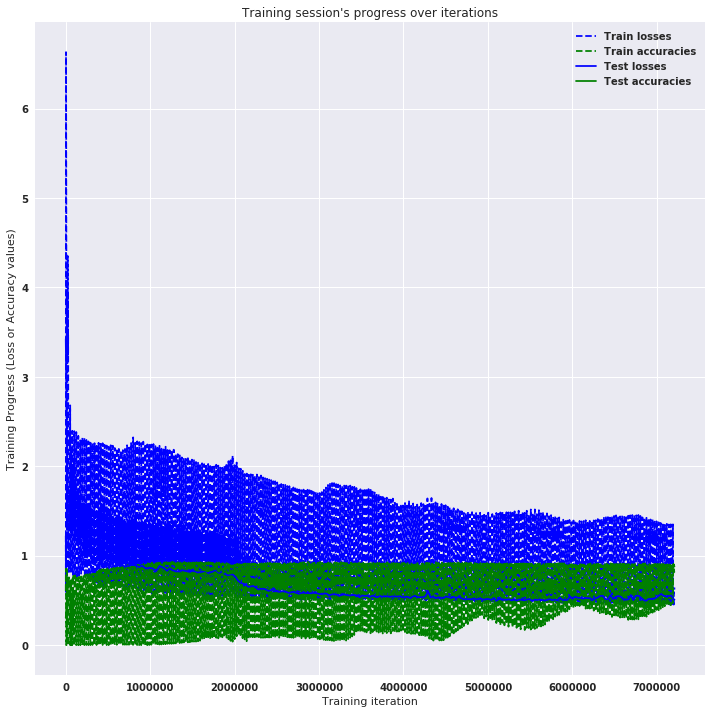

In [99]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

In [100]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 88.1644964218%

Precision: 88.8723918353%
Recall: 88.1644934804%
f1_score: 87.3345333019%
Normalized confusion matrix


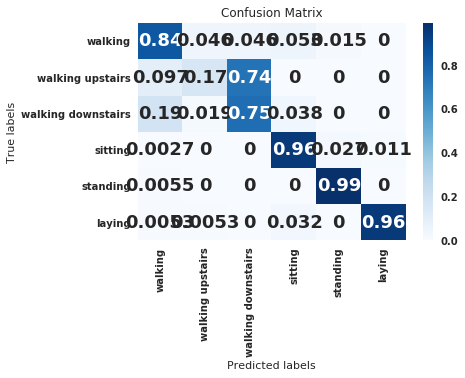

In [101]:
# Results
# predictions = y_train_pred
# y_test = y_train
print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))


confusion_matrix = metrics.confusion_matrix(y_test, predictions)
plot_cm(confusion_matrix, LABELS)
plt.show()

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,target_names=LABELS))

                    precision    recall  f1-score   support

           walking       0.85      0.84      0.84       131
  walking upstairs       0.60      0.17      0.26        72
walking downstairs       0.40      0.75      0.53        53
           sitting       0.96      0.96      0.96       370
          standing       0.94      0.99      0.97       182
            laying       0.98      0.96      0.97       189

       avg / total       0.89      0.88      0.87       997



In [24]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 84  10   7  28  15   1]
 [ 53  16   4   0   2   0]
 [ 16  10  38   5   3   0]
 [  3   0   1 341   2  27]
 [  5   1   2  59 116   0]
 [  0   0   0   8   0 182]]
Normalized confusion matrix
[[0.58 0.07 0.05 0.19 0.1  0.01]
 [0.71 0.21 0.05 0.   0.03 0.  ]
 [0.22 0.14 0.53 0.07 0.04 0.  ]
 [0.01 0.   0.   0.91 0.01 0.07]
 [0.03 0.01 0.01 0.32 0.63 0.  ]
 [0.   0.   0.   0.04 0.   0.96]]


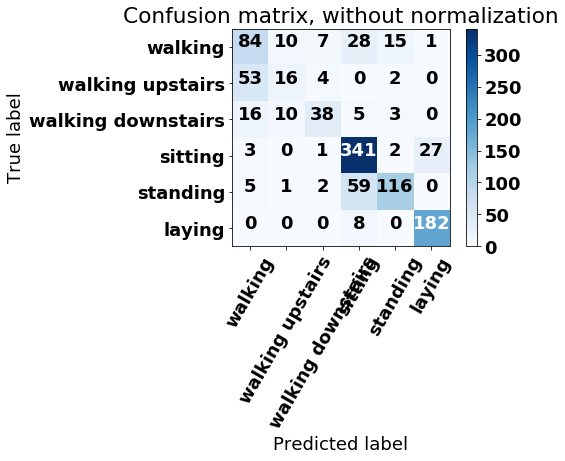

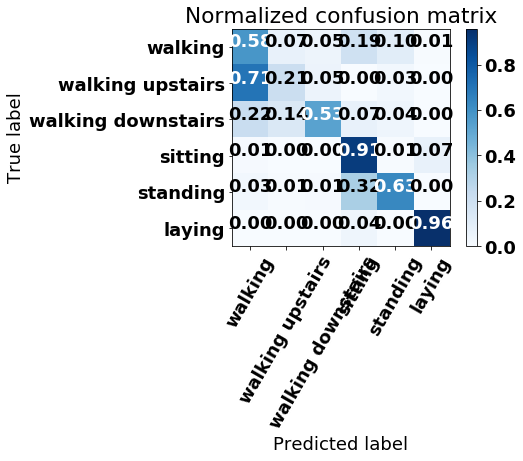

In [25]:
y_pred_all = predictions
y_test_all = y_test
cnf_matrix = confusion_matrix
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS, normalize=True,
                      title='Normalized confusion matrix')
# plt.savefig(save_with_name+'.png')
plt.show()

In [34]:
np.save('y_test_all', y_test)
np.save('y_pred_all', predictions)